# Inteligentná analýza údajov 2019/2020 - Projekt
## Tretia časť - Strojové učenie
## Ondrej Jedinák, František Tibenský (podieľ práce členov 50/50%)

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

from IPython.display import display


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


pd.options.display.max_colwidth=130
pd.set_option("display.max_columns", None)

# Predspracovanie

Zadefinujeme si funkcie na transformácie ktoré sme vytvorili v predchádzajúcej fáze. Tiež sme pridali novú funkciu na zakódovanie textových atribútov.

In [2]:
class ColNameUnifier(TransformerMixin):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        cols=df.columns
        cols_new=[]
        for col in cols:
            cols_new.append(col.replace("-","_"))
        df.rename(columns={i:j for i,j in zip(cols,cols_new)}, inplace=True)
        return df

class SpaceRemover(TransformerMixin):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        for col in df:
            if df[col].dtype=='object':
                df[col]=df[col].str.strip()
        return df

class MissingDataUnifier(TransformerMixin):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df=df.replace('?',np.NaN)
        df=df.replace('??',np.NaN)
        return df

class DateFormatter(TransformerMixin):
    def __init__(self, date_col="date_of_birth"):
        self.col = date_col
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        col=self.col
        df[col]=df[col].str.replace(" .*","")
        df[col]=df[col].str.replace("/","-")
        df[col]=df[col].str.replace(r'([0-9]{2})-([0-9]{2})-([0-9]{4})', r'\3-\2-\1')
        
        df[col]=df[col].str.replace(r'^(19-[0-9]{2}-[0-9]{2})',r'19\1')
        df[col]=df[col].str.replace(r'^([2-9][0-9]-[0-9]{2}-[0-9]{2})',r'19\1')
        df[col]=df[col].str.replace(r'^([0-1][0-9]-[0-9]{2}-[0-9]{2})',r'20\1')
        return df

class AgeComputer(TransformerMixin):
    def __init__(self, curr_date="now", age_col="age", date_col="date_of_birth"):
        self.curr_date = curr_date
        self.age_col = age_col
        self.date_col = date_col
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.age_col]=((pd.to_datetime(self.curr_date)-pd.to_datetime(df[self.date_col])).astype('<m8[Y]'))
        return df

class MonthExtractor(TransformerMixin):
    def __init__(self, date_col="date_of_birth"):
        self.col = date_col
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.col]=df[self.col].str.replace(r'([0-9]{4})-([0-9]{2})-([0-9]{2})', r'\2').astype(str).astype(float)
        return df

class ColRenamer(TransformerMixin):
    def __init__(self, col, new_name):
        self.col = col
        self.new_name = new_name
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df.rename(columns={self.col: self.new_name},inplace=True)
        return df

class Capitalizer(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        for col in self.cols:
            df[col]=df[col].str.capitalize()
        return df

class JsonSplitter(TransformerMixin):
    def __init__(self, col="medical_info"):
        self.col = col
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        col=self.col
        df[col]=df[col].replace(np.NaN,"{}")
        df[col]=df[col].str.replace("'",'"')
        df=df.join(df[col].apply(json.loads).apply(pd.Series).astype(float))
        df=df.drop(columns=col)
        return df

class SpaceUnifier(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        for col in self.cols:
            df[col]=df[col].str.replace("_","-")
        return df

class EduNumFixer(TransformerMixin):
    def __init__(self, edu_num_col="education_num"):
        self.col = edu_num_col
        
    def fit(self, df, y=None):
        return self
    
    def edu_num_fix(self,val):
        if val<0:
            val*=-1
        if val>100:
            val/=100
        return val
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.col]=df[self.col].apply(self.edu_num_fix)
        return df

class EduAndEduNumUnifier(TransformerMixin):
    def __init__(self, edu_num_col="education_num", edu_col="education"):
        self.edu_num_col = edu_num_col
        self.edu_col = edu_col
        
    def fit(self, df, y=None):
        self.edu={}
        for i in range(1,17):
            self.edu[str(df[self.edu_col][df[self.edu_num_col]==i].value_counts()).split(" ")[0]]=i
        return self

    def edu_to_num(self,val):
        if val in self.edu:
            return self.edu[val]
        else:
            return np.NaN
    
    def transform(self, df, y=None):
        df=df.copy()
        
        df[self.edu_col]=df[self.edu_col].apply(self.edu_to_num)
        df[self.edu_col].fillna(df[self.edu_num_col], inplace=True)
        df = df.drop(columns=[self.edu_num_col])
        return df

class BinaryFixer(TransformerMixin):
    
    def __init__(self, col, true, false, new_name=""):
        self.col = col
        self.true = true
        self.false = false
        self.new_name = new_name
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.col]=df[self.col].str.lower()
        df[self.col]=df[self.col].str.replace(self.false,"0")
        df[self.col]=df[self.col].str.replace(self.true,"1")
        df[self.col]=df[self.col].astype(float)
        
        if self.new_name !="":
            df.rename(columns={self.col: self.new_name},inplace=True)

        return df

class Deduplicator(TransformerMixin):
    
    def __init__(self, name_col="name", addr_col="address"):
        self.name_col = name_col
        self.addr_col = addr_col
    
    def fit(self, df, y=None):
        return self
    
    def aggr(self,val):
        o=set()
        for v in val:
            if not pd.isna(v):
                o.add(v)
        if len(o)==0:
            return np.NaN
        elif len(o)>1:
            print("Pozor: viac moznych hodnot!")
            print(o)
        return o.pop()
    
    def transform(self, df, y=None):
        df=df.copy()
        df=df.groupby([self.name_col, self.addr_col]).aggregate(self.aggr).reset_index()
        return df

class StateExtractor(TransformerMixin):
    
    def __init__(self, addr_col="address"):
        self.col=addr_col
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.col]=df[self.col].str.replace(r".*\r?\n[A-Za-z ]+,? ([A-Z]{2}).*",r"\1")
        df.rename(columns={self.col: "state"},inplace=True)
        return df

class ColDropper(TransformerMixin):
    
    def __init__(self, cols):
        self.cols=cols
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df=df.drop(columns=self.cols)
        return df

class MalePregnancyFixer(TransformerMixin):
    
    def __init__(self, preg_col="pregnant",sex_col="sex", male_val="Male"):
        self.preg_col=preg_col
        self.sex_col=sex_col
        self.male_val = male_val
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df.loc[df[self.sex_col] == self.male_val, self.preg_col] = 0
        return df

class NanModeReplacer(TransformerMixin):
    
    def __init__(self, cols):
        self.cols=cols
    def fit(self, df, y=None):
        self.mode={}
        for col in self.cols:
            self.mode[col]=df[col].mode()[0]
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        for col in self.cols:
            df[col]=df[col].fillna(self.mode[col])
        return df

class CapitalFixer(TransformerMixin):
    
    def __init__(self, loss_col="capital_loss", gain_col="capital_gain", new_name="capital"):
        self.new_name=new_name
        self.loss=loss_col
        self.gain=gain_col

    def fit(self, df, y=None):
        self.g_med=df[self.gain].median()
        self.l_med=df[self.loss].median()
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.loss]=df[self.loss].fillna(self.l_med)
        df[self.gain]=df[self.gain].fillna(self.g_med)
        df[self.gain]=df[self.gain]-df[self.loss]
        df.rename(columns={self.gain: self.new_name},inplace=True)
        df = df.drop(columns=[self.loss])
        return df

class ValueReplacer(TransformerMixin):
    
    def __init__(self, col, replace):
        self.col=col
        self.replace=replace

    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        for rep in self.replace:
            new=rep[1]
            for old in rep[0]:
                df[self.col]=df[self.col].replace(old,new)
        
        return df

class MaritalStatusNanReplacer(TransformerMixin):
    
    def __init__(self, ms_col="marital_status", rel_col="relationship"):
        self.ms_col=ms_col
        self.rel_col=rel_col

    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df.loc[df[self.rel_col] == "Spouse", self.ms_col]=df.loc[df[self.rel_col] == "Spouse", self.ms_col].fillna("Married")
        df[self.ms_col]=df[self.ms_col].fillna("Never-married")
        return df

class AvgFiller(TransformerMixin):
    def __init__(self,column):
        self.column = column
        
    def fit(self, df, y=None):
        self.avg = df[self.column].mean();   
        return self
    
    def transform(self, df, y=None):
        df = df.copy()
        df.fillna({self.column:self.avg},inplace=True)
        return df

class AvgSegmentFiller(TransformerMixin):
    def __init__(self,column, seg_col = "age"):
        self.column = column
        self.seg_col = seg_col
        
    def fit(self,df,y=None):
        self.avg={}
        self.mx=(df[self.seg_col].max().astype(int) // 10)+1
        for i in range(0,self.mx):
            self.avg[i]=df[(df[self.seg_col]>=i*10) & (df[self.seg_col]<((i+1)*10))][self.column].mean()
        return self
    
    def transform(self, df, y=None):
        df = df.copy()
        for i in range(0,self.mx):
            df.loc[(df[self.seg_col]>=(i*10)) & (df[self.seg_col]<((i+1)*10)),self.column]=df.loc[(df[self.seg_col]>=(i*10)) & (df[self.seg_col]<((i+1)*10)),self.column].fillna(self.avg[i])
        return df

class CubeRootTransformer(TransformerMixin):
    def __init__(self,column):
        self.column = column
        
    def fit(self, df, y=None):
        return self
    
    def transform(self,df,y=None):
        df = df.copy()
        df[self.column] = np.cbrt(df[self.column])
        return df

class LogTransformer(TransformerMixin):
    def __init__(self,column):
        self.column = column
        
    def fit(self, df, y=None):
        return self
    
    def transform(self,df,y=None):
        df = df.copy()
        df[self.column] = np.log(df[self.column])
        return df

class OutlierClipper(TransformerMixin):
    
    def __init__(self, cols, up=0.95, low=0.05):
        self.cols=cols
        self.up=up
        self.low=low
        
    def fit(self, df, y=None):
        self.upper={}
        self.lower={}
        for col in self.cols:
            self.upper[col]=df[col].quantile(self.up)
            self.lower[col]=df[col].quantile(self.low)
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        for col in self.cols:
            df[col]=df[col].clip(upper=self.upper[col], lower=self.lower[col])
        return df

class WorkHoursFixer(TransformerMixin):
    
    def __init__(self, col="hours_per_week"):
        self.col = col
        
    def fit(self,df,y=None):
        return self
        
    def transform(self,df,y=None):
        df = df.copy()
        df[self.col]= df[self.col]//10      
        return df

class EmptyClassDropper(TransformerMixin):
    
    def __init__(self, col="class"):
        self.col = col
        
    def fit(self,df,y=None):
        return self
        
    def transform(self,df,y=None):
        df = df.copy()
        if(self.col in df.columns):
            df = df[pd.notnull(df[self.col])]  
        return df.reset_index(drop=True)

class StringEncoder(TransformerMixin):
    
    def __init__(self, cols=["marital_status","race","occupation","relationship","native_country","workclass","state"]):
        self.cols = cols
        
    def fit(self,df,y=None):
        self.encoders={}
        cl={}
        for col in self.cols:
            cl[col]=["unknown"]
        for col in self.cols:
            self.encoders[col]=LabelEncoder().fit(df.append(pd.DataFrame(cl),ignore_index=True,sort=False)[col])
        return self
        
    def transform(self,df,y=None):
        df = df.copy()
        for col in self.cols:
            for i in df[col].unique():
                if i not in self.encoders[col].classes_:
                    df[col]=df[col].replace(i,"unknown")
                

        for col in self.cols:
            df[col] = self.encoders[col].transform(df[col])
        return df

Vytvoríme si pipeliny pre spracovanie datasetov. Jednu pre personal, other, a spojený dataset.

In [3]:
personal_pipeline = Pipeline(steps=[
    ('colnameunifier', ColNameUnifier()),
    ('spaceremover', SpaceRemover()),
    ('missingdataunifier', MissingDataUnifier()),
    ('dateformatter', DateFormatter()),
    ('agecomputer', AgeComputer()),
    ('monthextractor', MonthExtractor()),
    ('bthdrenamer', ColRenamer("date_of_birth","birth_month"))
    

])
other_pipeline = Pipeline(steps=[
    ('colnameunifier', ColNameUnifier()),
    ('spaceremover', SpaceRemover()),
    ('missingdataunifier', MissingDataUnifier()),
    ('wccapitalizer', Capitalizer(["workclass"])),
    ('jsonsplitter', JsonSplitter()),
    ('spaceunifier', SpaceUnifier(["education"])),
    ('edunumfixer', EduNumFixer()),
    ('edunumunifier', EduAndEduNumUnifier()),
    ('pregbinfixer', BinaryFixer("pregnant", "(^t.*$)", "(^f.*$)")),
    ('deduplicator', Deduplicator())
])
merged_pipeline = Pipeline(steps=[
    ('stateextractor', StateExtractor()),
    ('namedropper', ColDropper(["name"])),
    ('pregnanreplace', NanModeReplacer(["pregnant"])),
    ('malepregfixer', MalePregnancyFixer()),
    ('sexbinfixer', BinaryFixer("sex", "male", "female", "male")),
    ('incomebinfixer', BinaryFixer("income", ">50k", "<=50k", "income_over_fifty")),
    ('incomenanreplacer', NanModeReplacer(["income_over_fifty"])),
    ('capitalfixer', CapitalFixer()),
    ('maritalfixer', ValueReplacer("marital_status",[[["Married-civ-spouse","Married-AF-spouse"],"Married"],[["Married-spouse-absent","Divorced","Separated","Widowed"],"Previously_married"]])),
    ('relreplacer', ValueReplacer("relationship",[[["Husband","Wife"],"Spouse"]])),
    ('relnanreplacer', NanModeReplacer(["relationship"])),
    ('maritalnanreplacer', MaritalStatusNanReplacer()),
    ('othernanreplacer', NanModeReplacer(["race", "workclass", "native_country" ,"occupation"])),
    ('fnlwgtfill', AvgFiller("fnlwgt")),
    ('fnlwgtclip', OutlierClipper(["fnlwgt"])),
    ('skewgfill', AvgSegmentFiller("skewness_glucose")),
    ('skewgclip', CubeRootTransformer("skewness_glucose")),
    ('meangfill', AvgSegmentFiller("mean_glucose")),
    ('meangclip', OutlierClipper(["mean_glucose"])),
    ('kurtgfill', AvgSegmentFiller("kurtosis_glucose")),
    ('kurtgclip', OutlierClipper(["kurtosis_glucose"])),
    ('stdgfill', AvgFiller("std_glucose")),
    ('stdclip', OutlierClipper(["std_glucose"])),
    ('hpwfill',AvgFiller("hours_per_week")),
    ('hpwfix', WorkHoursFixer()),
    ('skewofill', AvgFiller("skewness_oxygen")),
    ('wkewoclip', CubeRootTransformer("skewness_oxygen")),
    ('meanofill', AvgSegmentFiller("mean_oxygen")),
    ('meanoclip', CubeRootTransformer("mean_oxygen")),
    ('kurtofill', AvgFiller("kurtosis_oxygen")),
    ('kurtoclip', OutlierClipper(["kurtosis_oxygen"])),
    ('stdofill', AvgSegmentFiller("std_oxygen")),
    ('stdoclip', LogTransformer("std_oxygen")),
    ('classdrop', EmptyClassDropper()),
    ('encode', StringEncoder())

])


Načítame všetky datasety a vykonáme na nich transformácie s fit_transform pre trénovací dataset a transform pre ostatné.

In [4]:
personal_data=pd.read_csv("data/personal_train.csv", index_col=0)
data=pd.read_csv("data/other_train.csv", index_col=0)

In [5]:
personal_data=personal_pipeline.fit_transform(personal_data)
data=other_pipeline.fit_transform(data)
data=personal_data.merge(data,on=("name","address"))
data=merged_pipeline.fit_transform(data)

In [6]:
train_data=data

In [7]:
personal_data=pd.read_csv("data/personal_valid.csv", index_col=0)
data=pd.read_csv("data/other_valid.csv", index_col=0)

In [8]:
personal_data=personal_pipeline.transform(personal_data)
data=other_pipeline.transform(data)
data=personal_data.merge(data,on=("name","address"))
data=merged_pipeline.transform(data)

In [9]:
valid_data=data

In [10]:
personal_data=pd.read_csv("data/personal_test.csv", index_col=0)
data=pd.read_csv("data/other_test.csv", index_col=0)

In [11]:
personal_data=personal_pipeline.transform(personal_data)
data=other_pipeline.transform(data)
data=personal_data.merge(data,on=("name","address"))
data=merged_pipeline.transform(data)

In [12]:
test_data=data

In [13]:
del data
del personal_data

In [14]:
train_data

,state,age,male,birth_month,race,marital_status,occupation,pregnant,relationship,skewness_glucose,mean_glucose,capital,kurtosis_glucose,education,fnlwgt,class,std_glucose,income_over_fifty,native_country,hours_per_week,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,38,58.0,1.0,3.0,4,1,7,0.0,0,-0.463424,119.242188,0.0,0.012622,9.0,321896.0,0.0,49.065286,0.0,34,4.0,3,1.456315,2.928826,8.293978,4.346820
1,18,57.0,0.0,11.0,0,2,3,0.0,2,1.338272,82.070312,0.0,0.860951,11.0,134220.0,0.0,38.530261,0.0,34,4.0,3,0.840839,2.298236,15.240830,7.773285
2,8,60.0,1.0,12.0,4,0,0,0.0,3,1.686564,78.218750,0.0,1.540387,9.0,39564.2,1.0,40.637871,1.0,34,4.0,0,2.765499,4.006216,2.492557,1.691896
3,7,66.0,0.0,3.0,4,0,7,0.0,3,2.236314,61.718750,0.0,2.266661,13.0,159442.0,1.0,32.301543,0.0,34,4.0,3,2.452388,3.856827,3.201232,2.086822
4,8,65.0,1.0,12.0,4,1,7,0.0,2,3.029901,27.017188,0.0,5.028178,10.0,219211.0,1.0,35.907555,0.0,34,2.0,3,5.052567,4.204027,0.202820,-0.841347
5,7,54.0,0.0,5.0,4,1,0,0.0,2,-0.805877,124.085938,0.0,0.152932,9.0,198822.0,0.0,56.185806,0.0,34,3.0,3,1.285388,2.627308,9.332406,4.913280
6,48,53.0,1.0,5.0,4,0,3,0.0,3,2.355614,69.906250,0.0,3.154100,12.0,122206.0,1.0,34.185258,1.0,34,5.0,4,3.843904,4.298630,1.200914,0.654704
7,22,30.0,1.0,7.0,1,0,9,0.0,3,1.224338,76.484375,0.0,0.898881,13.0,123983.0,0.0,40.383510,1.0,21,5.0,3,1.396175,2.998264,8.333821,4.213439
8,13,60.0,1.0,3.0,4,1,7,0.0,2,-0.427609,129.820312,0.0,0.101646,7.0,194612.0,0.0,47.896443,0.0,34,2.0,3,1.185961,2.603557,10.756981,5.242260
9,10,52.0,0.0,6.0,2,1,6,0.0,4,1.881196,60.617188,0.0,1.990753,9.0,97136.0,1.0,36.952909,0.0,34,4.0,3,2.751876,4.023169,2.743937,1.866266


In [15]:
valid_data

,state,age,male,birth_month,race,marital_status,occupation,pregnant,relationship,skewness_glucose,mean_glucose,capital,kurtosis_glucose,education,fnlwgt,class,std_glucose,income_over_fifty,native_country,hours_per_week,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,13,48.0,1.0,7.0,4,0,7,0.0,3,0.736821,113.687500,0.0,0.038520,11.0,89040.0,0.0,45.326894,0.0,34,4.0,3,1.933427,3.447772,4.642782,2.793695
1,19,54.0,0.0,8.0,4,2,6,0.0,2,3.149815,34.406250,0.0,5.028178,10.0,175370.0,1.0,31.877558,0.0,34,4.0,3,3.460154,4.114727,1.731936,1.363972
2,1,48.0,0.0,1.0,2,2,6,0.0,4,0.722591,101.328125,0.0,0.374884,10.0,212437.0,0.0,43.385465,0.0,34,4.0,3,1.506475,2.958219,7.134172,3.891975
3,4,60.0,0.0,11.0,4,1,9,0.0,0,3.285317,27.017188,-1564.0,5.028178,11.0,196584.0,1.0,32.258590,1.0,34,4.0,3,4.100273,4.177070,0.742921,-0.446490
4,29,36.0,1.0,8.0,4,0,5,0.0,3,-0.624251,134.835938,0.0,-0.192718,9.0,92036.0,0.0,50.723635,1.0,34,4.0,3,1.314093,2.909733,9.078860,4.477226
5,22,61.0,1.0,7.0,4,1,5,0.0,0,0.890322,117.578125,0.0,0.450528,9.0,223811.0,0.0,40.392529,0.0,34,4.0,3,1.040171,2.592470,14.422720,6.147397
6,0,29.0,1.0,10.0,4,0,11,0.0,3,1.022241,110.710938,0.0,0.224973,9.0,149726.0,0.0,39.075678,1.0,34,4.0,3,1.125243,2.653447,12.274924,5.506547
7,24,47.0,1.0,11.0,4,0,9,0.0,3,-0.710866,119.335938,0.0,0.151041,13.0,359828.0,0.0,52.812356,1.0,34,4.0,3,1.812212,3.373230,5.520140,3.156816
8,48,45.0,0.0,5.0,2,2,7,0.0,4,3.199490,40.789062,0.0,5.028178,9.0,174491.0,1.0,31.172334,0.0,34,4.0,1,3.807841,4.361731,1.161472,0.154329
9,16,44.0,1.0,12.0,4,0,9,0.0,3,-0.527208,120.914062,0.0,0.101363,10.0,262352.0,0.0,48.458589,0.0,34,3.0,3,1.220046,2.413687,12.471247,6.154211


In [16]:
test_data

,state,age,male,birth_month,native_country,capital,fnlwgt,occupation,relationship,race,kurtosis_glucose,income_over_fifty,marital_status,pregnant,std_glucose,skewness_glucose,mean_glucose,workclass,education,hours_per_week,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,35,17.0,0.0,1.0,34,0.0,356238.0,7,0,4,-0.192718,1.0,1,0.0,51.035153,-0.484759,128.304688,3,12.0,8.0,1.346534,2.648638,9.122319,4.841993
1,8,14.0,0.0,8.0,34,0.0,149040.0,7,0,4,0.277006,0.0,1,0.0,48.739947,-0.434913,118.664062,3,8.0,4.0,1.383769,2.682359,8.510619,4.641798
2,18,17.0,0.0,9.0,34,0.0,207611.0,7,0,4,-0.003375,0.0,1,0.0,49.281716,-0.672013,132.625000,3,9.0,5.0,1.422829,2.725681,8.090141,4.475756
3,10,49.0,1.0,5.0,34,0.0,111423.0,2,0,4,0.158968,0.0,1,0.0,54.300038,-0.816642,110.882812,5,13.0,5.0,1.550608,3.185605,7.043242,3.724052
4,31,50.0,1.0,1.0,34,7688.0,210827.0,9,3,4,0.792340,1.0,0,0.0,37.967165,1.290750,86.203125,4,13.0,4.0,1.113678,2.485887,13.620135,6.095408
5,0,52.0,1.0,9.0,34,0.0,76127.0,0,3,4,-0.192718,1.0,0,0.0,45.683946,0.479058,124.976562,3,12.0,3.0,1.707876,3.280672,5.563959,3.152122
6,0,66.0,1.0,9.0,34,0.0,373196.2,3,3,4,4.248566,0.0,0,0.0,34.794008,2.731847,39.367188,3,13.0,4.0,3.992093,4.261272,0.893260,-0.357485
7,46,54.0,1.0,4.0,34,0.0,232719.0,9,3,4,0.192567,0.0,0,0.0,44.727413,0.679844,114.789062,3,14.0,5.0,1.121488,2.354642,14.878314,6.716341
8,42,49.0,1.0,9.0,34,0.0,180052.0,7,2,4,2.140574,0.0,1,0.0,33.678243,2.078801,68.601562,3,9.0,4.0,2.369642,3.933761,3.638970,2.255871
9,40,62.0,1.0,11.0,34,0.0,189656.0,12,0,4,3.035313,1.0,1,0.0,42.760918,2.212071,57.562500,3,13.0,6.0,2.642673,3.872714,2.888628,1.993304


# Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

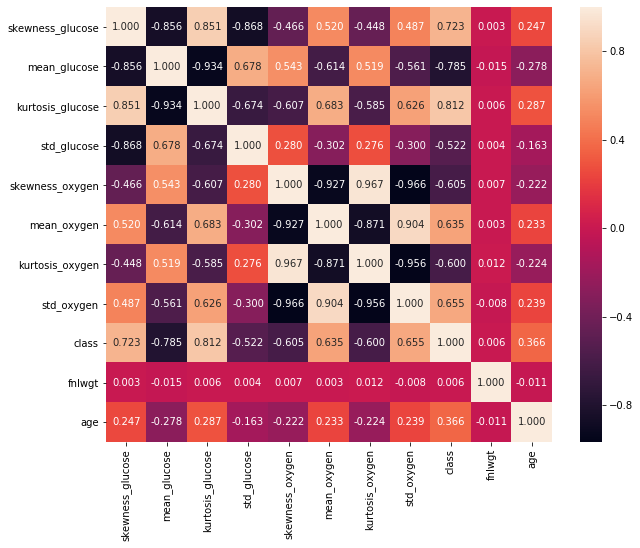

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(train_data[['skewness_glucose', 'mean_glucose','kurtosis_glucose','std_glucose','skewness_oxygen', 'mean_oxygen','kurtosis_oxygen','std_oxygen','class','fnlwgt','age']].corr(), ax=ax, annot=True, fmt=".3f")

Na vytvorenie manuálneho klasifikátora sme sa rozhodli použiť ako prediktory medicínske údaje a vek. Z nich vyberieme 3 medicínske údaje a vek, aby sme vytvorili vlastný rozhodovací strom a vyskúšame ho. Podľa heatmapy nám najväčšiu úroveň korelácie kurtosis_glucose a ňou korelujú mean_glucose a vek.


In [18]:
class Predictor(TransformerMixin):

    def fit(self,df,y=None):
        self.kurt=df["kurtosis_glucose"].mean();
        self.mean=df["mean_glucose"].mean();
        self.age=df["age"].mean();
        self.skew=df["skewness_glucose"].mean();
        return self
        
    def predict(self,row,mean_kurtosis, mean_mean, mean_age, mean_skewness):  
    
        if row.kurtosis_glucose > mean_kurtosis:
            if row.age > mean_age:
                if row.skewness_glucose > mean_skewness:
                    if row.mean_glucose < mean_mean:
                        return 1
                    else:
                        return 1
                else:
                    if row.skewness_glucose > mean_skewness:
                        if row.mean_glucose < mean_mean:
                            return 1
                        else:
                            return 0
            else:
                if row.skewness_glucose> mean_skewness:
                    if row.mean_glucose < mean_mean:
                        return 1
                    else:
                        return 0
                else:
                    if row.skewness_glucose > mean_skewness:
                        if row.mean_glucose < mean_mean:
                            return 1
                        else:
                            return 0

        else:
            if row.age < mean_age:
                if row.skewness_glucose < mean_skewness:
                    if row.mean_glucose > mean_mean:
                        return 0
                    else:
                        return 0
                else:
                    if row.mean_glucose > mean_mean:
                        return 0
                    else:
                        return 1
            else:
                if row.skewness_glucose < mean_skewness:
                    if row.mean_glucose > mean_mean:
                        return 0
                    else:
                        return 1
                else:
                    if row.mean_glucose > mean_mean:
                        return 0
                    else:
                        return 1
        
    def transform(self,df,y=None):
        prediction = []
        for row in df.itertuples():
            prediction.append(self.predict(row,self.kurt, self.mean, self.age, self.skew))
        prediction = [0 if v is None else v for v in prediction]

        return pd.Series(prediction)

Vytvoríme si funckiu na predikciu. Najprv sa pomocou fit zistia potrebné hodnoty na trénovaciom datasete, a potom sa sa využijú pri predikcií na validovaciom.

In [19]:
vlastny_strom=Predictor().fit(train_data)
prediction=vlastny_strom.transform(valid_data)

In [20]:
confusion_matrix(list(valid_data['class']), list(prediction))

array([[792, 172],
       [ 27, 319]], dtype=int64)

In [21]:
print(classification_report(list(valid_data['class']), list(prediction)))

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       964
         1.0       0.65      0.92      0.76       346

    accuracy                           0.85      1310
   macro avg       0.81      0.87      0.83      1310
weighted avg       0.88      0.85      0.86      1310



In [22]:
accuracy_score(list(valid_data['class']), list(prediction))

0.8480916030534351

# Použitie scikit-learn klasifikátora

In [23]:
x = train_data.drop(columns=['class'])
y = train_data['class']

strom = DecisionTreeClassifier(criterion='entropy').fit(x,y)

Natrénujeme si klasifikátor na trénovacích dátach.

In [24]:
prediction2 = strom.predict(valid_data.drop(columns=['class']))

Spustíme predikciu na validačných dátach a zistíme výsledky.

In [25]:
confusion_matrix(list(valid_data['class']), list(prediction2))

array([[915,  49],
       [ 26, 320]], dtype=int64)

In [26]:
print(classification_report(list(valid_data['class']), list(prediction2)))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       964
         1.0       0.87      0.92      0.90       346

    accuracy                           0.94      1310
   macro avg       0.92      0.94      0.93      1310
weighted avg       0.94      0.94      0.94      1310



In [27]:
accuracy_score(list(valid_data['class']), list(prediction2))

0.9427480916030534

V tomto prípade nám vyšla predikcia presnejšie ako pomocou nášho vlastného klasifikátora.

# Optimalizácia hyperparametrov

Postupne vyskúšame rôzne kombinácie parametrov a budeme sledovať ako sa predikcia zlepšuje.

In [28]:
strom = DecisionTreeClassifier(criterion='entropy').fit(x,y)
prediction2 = strom.predict(valid_data.drop(columns=['class']))
accuracy_score(list(valid_data['class']), list(prediction2))


0.9419847328244275

In [29]:
strom = DecisionTreeClassifier(criterion='entropy',max_depth=3).fit(x,y)
prediction2 = strom.predict(valid_data.drop(columns=['class']))
accuracy_score(list(valid_data['class']), list(prediction2))

0.9633587786259542

In [30]:
strom = DecisionTreeClassifier(criterion='entropy',max_depth=5).fit(x,y)
prediction2 = strom.predict(valid_data.drop(columns=['class']))
accuracy_score(list(valid_data['class']), list(prediction2))

0.9625954198473282

In [31]:
strom = DecisionTreeClassifier(criterion='entropy',max_depth=5).fit(x,y)
prediction2 = strom.predict(valid_data.drop(columns=['class']))
accuracy_score(list(valid_data['class']), list(prediction2))

0.9618320610687023

In [32]:
strom = DecisionTreeClassifier(criterion='gini',max_depth=3).fit(x,y)
prediction2 = strom.predict(valid_data.drop(columns=['class']))
accuracy_score(list(valid_data['class']), list(prediction2))

0.9603053435114504

In [33]:
strom = DecisionTreeClassifier(criterion='gini').fit(x,y)
prediction2 = strom.predict(valid_data.drop(columns=['class']))
accuracy_score(list(valid_data['class']), list(prediction2))

0.9396946564885497

In [34]:
strom = DecisionTreeClassifier(criterion='entropy',max_depth=4).fit(x,y)
prediction2 = strom.predict(valid_data.drop(columns=['class']))
accuracy_score(list(valid_data['class']), list(prediction2))

0.9648854961832061

In [35]:
strom = DecisionTreeClassifier(criterion='entropy').fit(x[["age","skewness_glucose","mean_glucose","kurtosis_glucose","std_glucose","skewness_glucose","mean_oxygen","kurtosis_oxygen","std_oxygen"]]
,y)
prediction2 = strom.predict(valid_data[["age","skewness_glucose","mean_glucose","kurtosis_glucose","std_glucose","skewness_glucose","mean_oxygen","kurtosis_oxygen","std_oxygen"]])
accuracy_score(list(valid_data['class']), list(prediction2))

0.9419847328244275

In [36]:
strom = DecisionTreeClassifier(criterion='entropy',max_depth=4).fit(x[["age","skewness_glucose","mean_glucose","kurtosis_glucose","std_glucose","skewness_glucose","mean_oxygen","kurtosis_oxygen","std_oxygen"]]
,y)
prediction2 = strom.predict(valid_data[["age","skewness_glucose","mean_glucose","kurtosis_glucose","std_glucose","skewness_glucose","mean_oxygen","kurtosis_oxygen","std_oxygen"]])
accuracy_score(list(valid_data['class']), list(prediction2))

0.9648854961832061

In [37]:
strom = DecisionTreeClassifier(criterion='entropy',max_depth=4,min_samples_split=40).fit(x[["age","skewness_glucose","mean_glucose","kurtosis_glucose","std_glucose","skewness_glucose","mean_oxygen","kurtosis_oxygen","std_oxygen"]]
,y)
prediction2 = strom.predict(valid_data[["age","skewness_glucose","mean_glucose","kurtosis_glucose","std_glucose","skewness_glucose","mean_oxygen","kurtosis_oxygen","std_oxygen"]])
accuracy_score(list(valid_data['class']), list(prediction2))


0.966412213740458

In [38]:
strom = DecisionTreeClassifier(criterion='entropy',max_depth=4,min_samples_split=40,min_samples_leaf=5).fit(x,y)
prediction2 = strom.predict(valid_data.drop(columns=['class']))
accuracy_score(list(valid_data['class']), list(prediction2))


0.9671755725190839

Nastavovaním parametrov sme sa dostali z úspešnosti okolo 93.9 percent na 96.7.

# Vyhodnotenie vplyvu riešenia hodnôt

Na úpravu textových hodnôt sme použili label encoding, čo však nie je ideálne riešenie lebo dané hodnoty väčšinou nemajú nejaké logické poradie ktoré by sa dalo číselne vyjadriť a lepšie by bolo použiť one hot encoding. Tiež by bolo vhodné zjednotiť niektoré hodnoty v stĺpcoch kde ich je veľké množstvo.

In [39]:
prediction2=pd.Series(prediction2).to_frame(name="pred")
d2=pd.concat([valid_data, prediction2], axis=1)

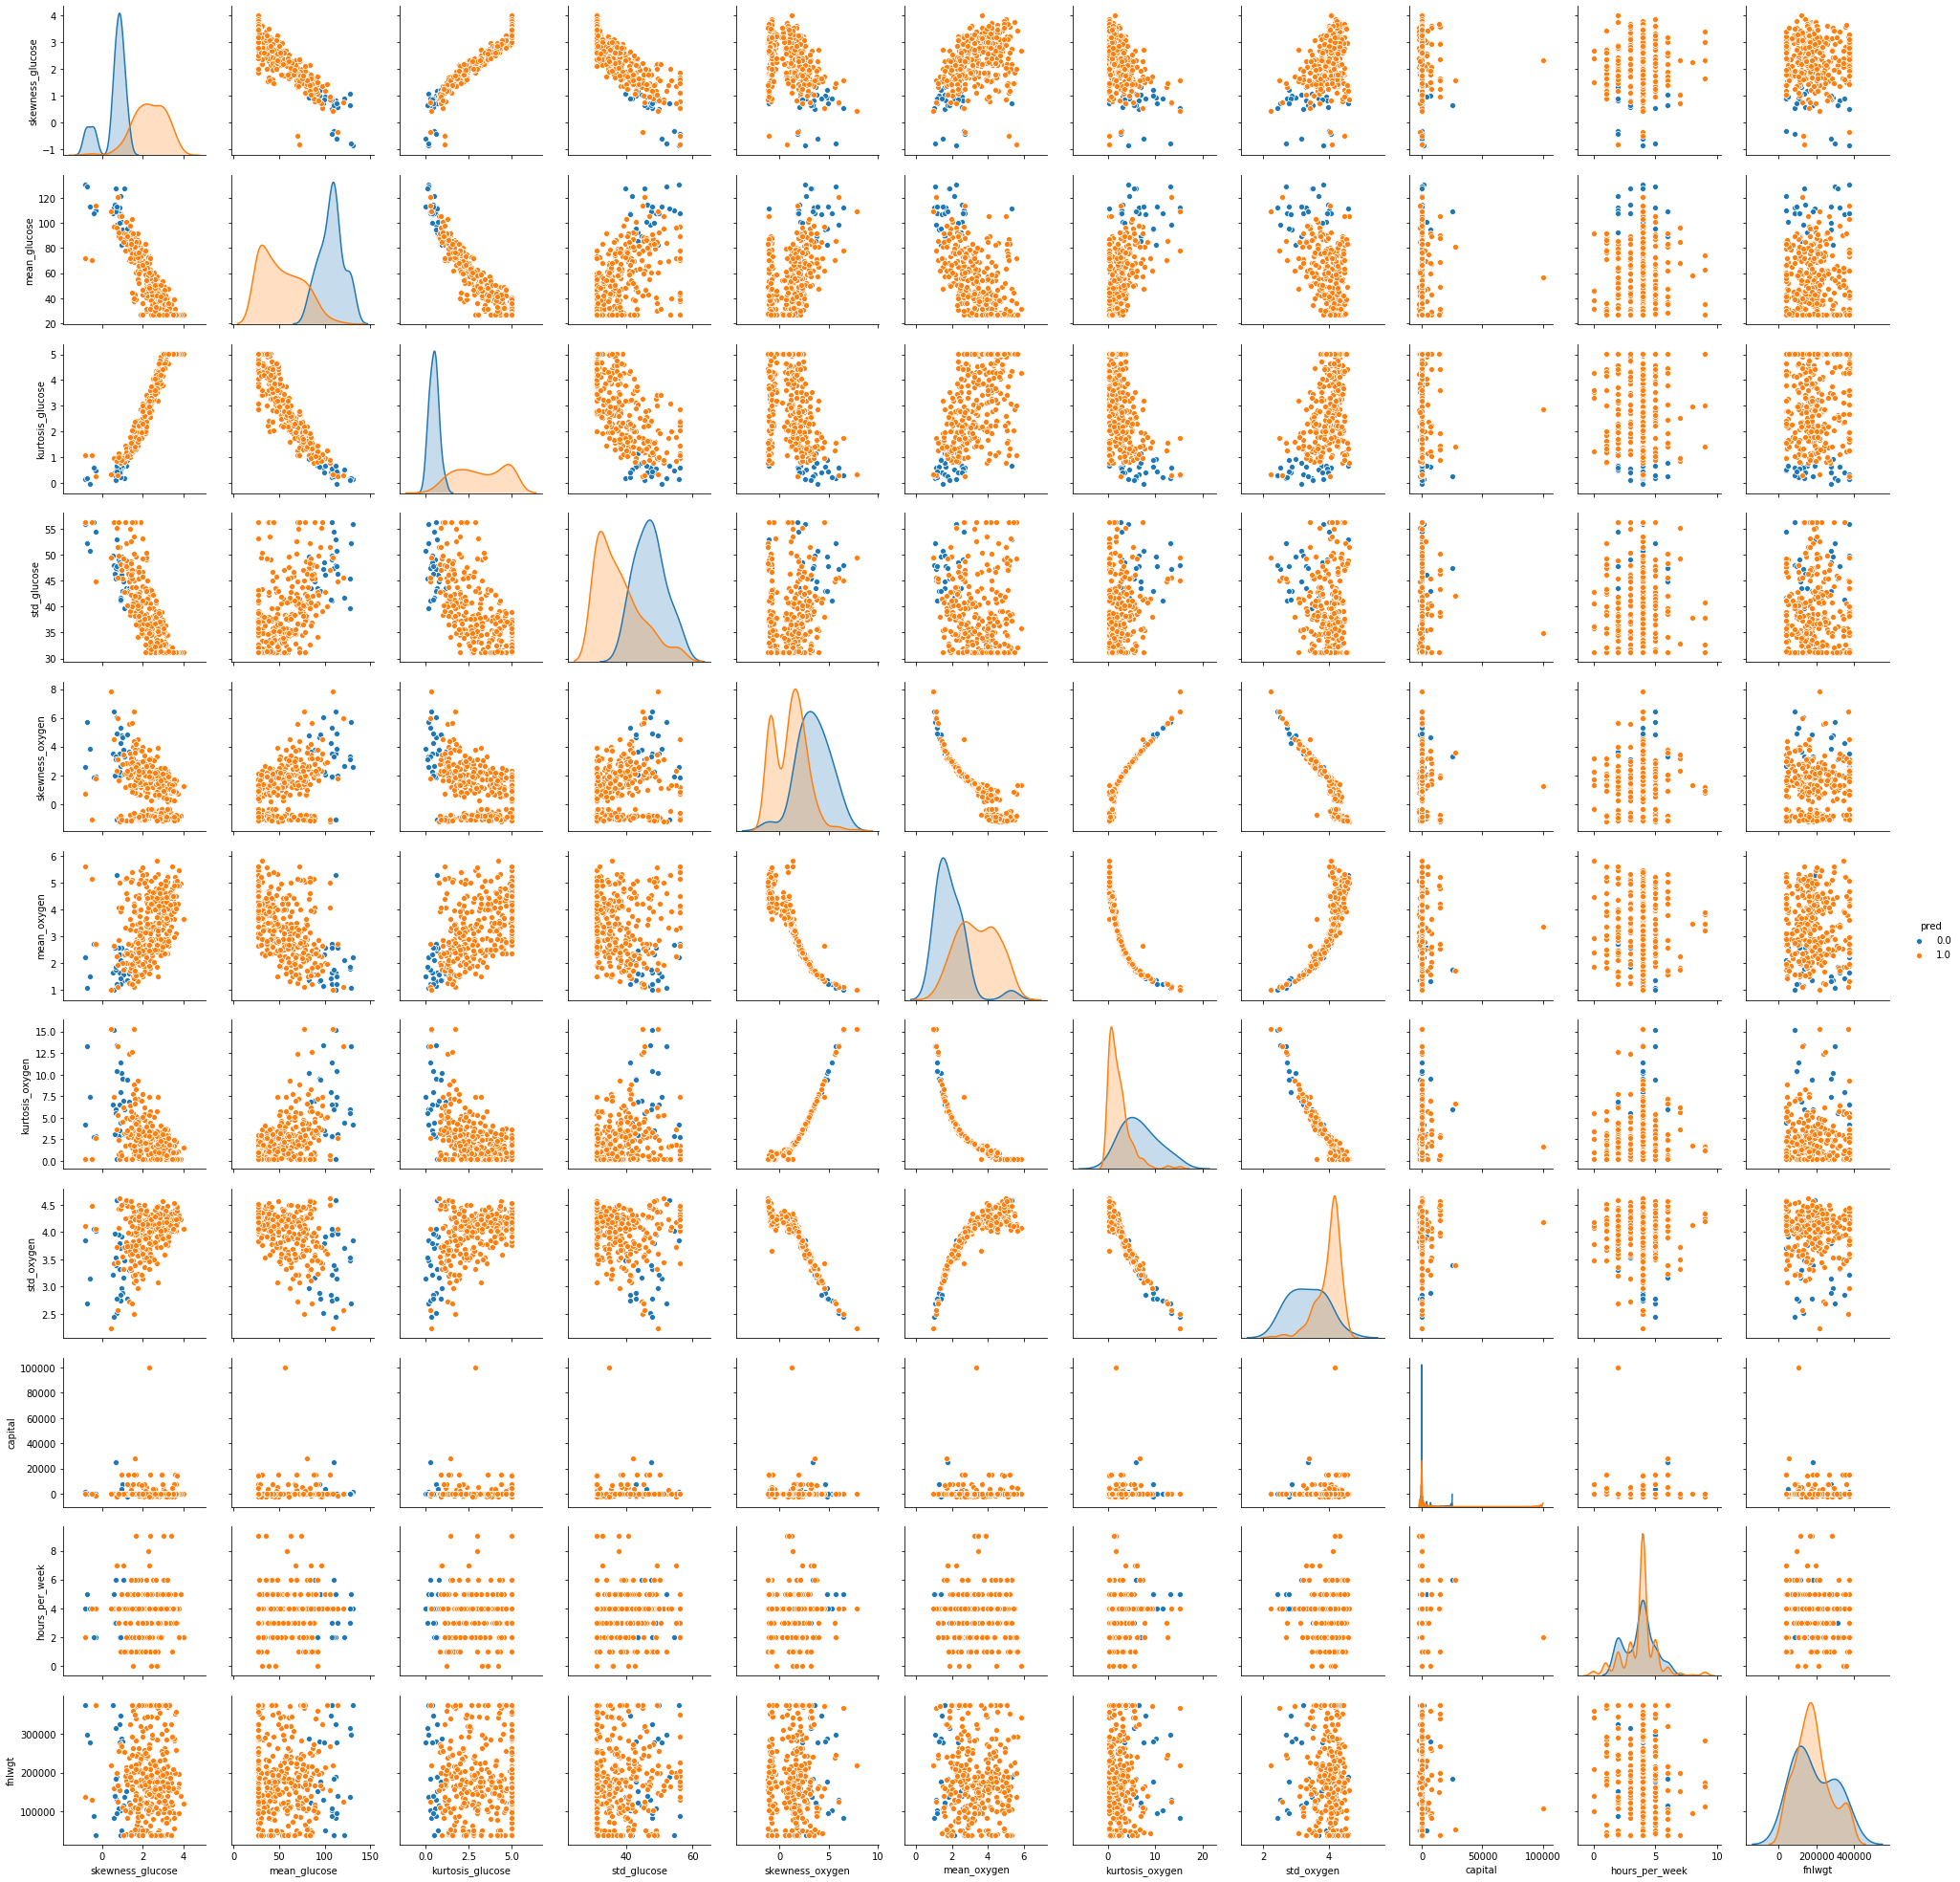

In [40]:
sns.pairplot(d2[d2["class"]==1], hue="pred", vars=['skewness_glucose', 'mean_glucose','kurtosis_glucose','std_glucose','skewness_oxygen', 'mean_oxygen','kurtosis_oxygen','std_oxygen','capital','hours_per_week','fnlwgt'])

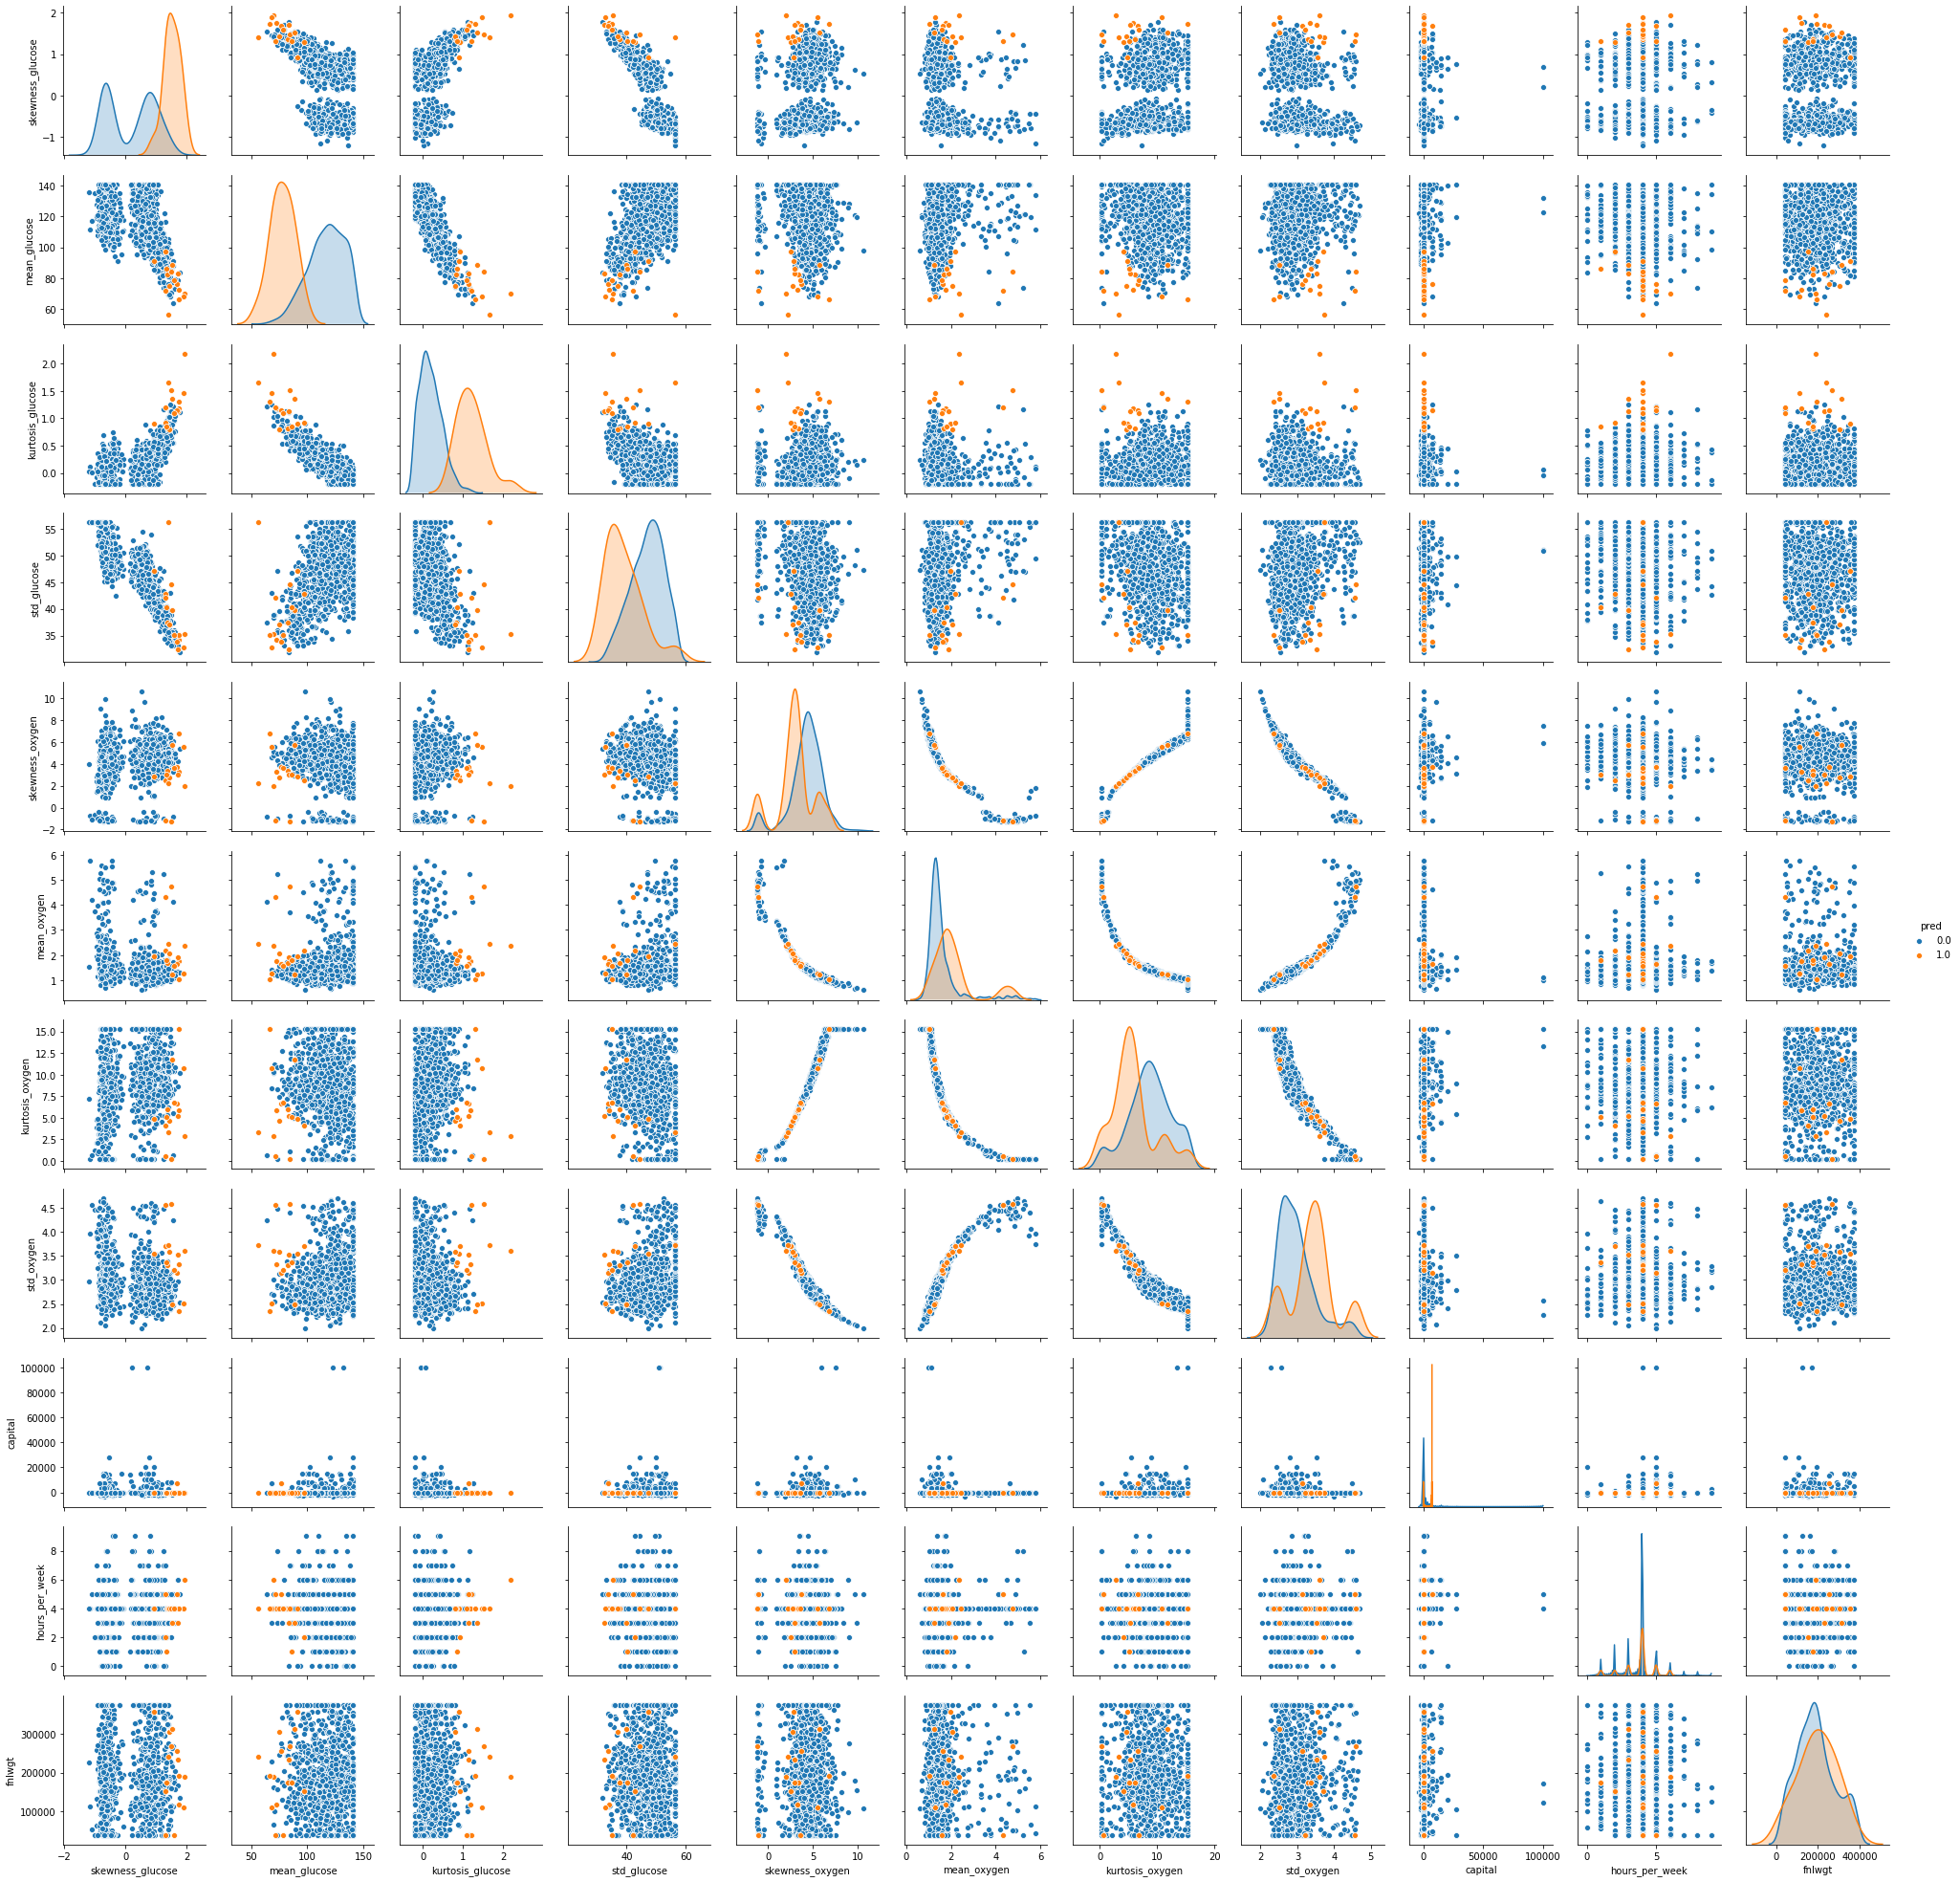

In [41]:
sns.pairplot(d2[d2["class"]==0], hue="pred", vars=['skewness_glucose', 'mean_glucose','kurtosis_glucose','std_glucose','skewness_oxygen', 'mean_oxygen','kurtosis_oxygen','std_oxygen','capital','hours_per_week','fnlwgt'])


Na týchto grafoch vidíme korelácie medzi rôznymi hodnotami rozdelené podľa class a či bol klasifikátor úspešný.

# Testovacie dáta

Nakoniec spravíme predikciu pre testovacie dáta oboma spôsobmi a uložíme si výsledky.

In [42]:
test_predict=pd.Series(strom.predict(test_data))

res=test_predict.to_frame(name="class")
res["class"]=res["class"].astype("int")
res.index.name="id"
res.to_csv("data\predict_sc.csv", encoding='utf-8', index=True)

own_test_predict=vlastny_strom.transform(test_data)

res=own_test_predict.to_frame(name="class")
res["class"]=res["class"].astype("int")
res.index.name="id"
res.to_csv("data\predict_own.csv", encoding='utf-8', index=True)